# AI_Assignment #2
## Hidden Markov Models
### Mohammad Javad Pesarakloo, SID = 810100103

# Table Of Contents<a id='toc0_'><a>
- [Introduction](#toc1_)
- [Evaluation](#toc2_)
    - [Precision](#toc2_1_)
    - [Recall](#toc2_2_)
    - [F1 Score](#toc2_3_)
    - [Questions on evaluation metrics](#toc2_4_)
    - [Eval Implementation](#toc2_5_)





In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io.wavfile as wav
import os
from python_speech_features import mfcc
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
import librosa
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal
import noisereduce as nr

C:\Users\javadpsk\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction
In this assignment, we are exploring hidden markov models which is a powerfull tool to process signals and find patterns in data.Our goal here is to classify some audio files which are represented by their **MFCC**.In each classification problem, we need some metrics to evaluate performance of the model;so we first introduce some metrics and tools to evaluate any machine learning model.Next we explore **Hidden Markov Models** in python;we first get familiar with the **hmmlearn** library;Then we implement an HMM class from scratch.Afterwards we do some preprocessings on data;this section has two subsection based on the query of the model and finally we evaluate our models and compare them togeather.

# Evaluation
On easiest way to evaluate a model is to simply find its accuracy with the following formula:
$$
            Accuracy = \frac{CorrectPredictions}{AllPredictions}
$$
But suppose we have a classifier which classifies every query to the label,say,A;then if the test datas are 99% of class A, we will get 99% accuracy which might seem very good, but we know that it is not.So we need some other metrics which we will describe as we go ahead.

## Precision
In precision metric, we want to see among all predictions of our model for a particular class, say A, how many of them were actually of class A:
$$
            precision_{class\_A} = \frac{TP_{A}}{TP_{A} + FP_{A}}
$$
## Recall
This time we want to see among all labels of a particular class, say A, how many of them were classified correctly:
$$
            recall_{class\_A} = \frac{TP_{A}}{TP_{A} + FN_{A}}
$$

## F1 Score
In an ideal classifier, both precision and recall should approach one;thus we need a metric which takes into account both precision and recall.This metric is called F1-Score and is calculated with the following formula:
$$
            F1\_Score = 2 \frac{precision \times recall}{precision + recall}
$$

## Questions on evaluation metrics
> * What kind of averaging does F1-Score use?What is the difference between this kind of averaging and arithmetic averaging and what is the point of using it here?
>> * This kind of averaging is called **harmonic averaging** which takes into account, inverse of numbers;thus it is more sensetive to low values and as we want precision and recall to be high, this metric can show good reaction to very low values of preicision and recall
> * What is the challenge of calculating this metrics in multi-class problems?
>> * When we have multiple classes, straightforward formula doesn't apply.So we need to calculate each metric for each class seperately which will give us multiple metrics and is hard to analyze.There are some solutions to get average from all this metrics:
>>> * Macro-averaging:Average the precision and recall across all classes to get the final macro-averaged precision and recall scores.
>>> * Micro-averaging:n this case, you must first calculate the total number of true positives (TP), false positives (FP), and false negatives (FN) predictions across all classes.Then, calculate the precision and recall using these total counts. 

Now we want to develop a class named **Eval** to evalute performance of our future models
## Eval Implementation


In [134]:
class Eval:
    def __init__(self, classLabels_, predictedLabels_):
        self.numberOfClasses = len(classLabels_)
        self.classLabels = classLabels_
        self.predictedLabels = predictedLabels_
        self.perClassSamples = len(predictedLabels_) // len(classLabels_)
        self.perClassPred = np.empty((self.numberOfClasses, 4), dtype=float) # n*4 array : TP, TN, FP, FN
        self.perClassMetrics = np.empty((self.numberOfClasses, 4), dtype=float) # n*4 array : accuracy, precision, recall, f1_score
        self.confusionMatrix = np.empty((self.numberOfClasses, self.numberOfClasses), dtype=int)
        self.totalAccuracy = 0

    
    def fillPerClassPred(self):
        for i in range(self.numberOfClasses):
            i_predicted = np.array([x for x in self.predictedLabels[i*self.perClassSamples:(i+1)*self.perClassSamples]])
            not_i_predicted = np.array([x for x in self.predictedLabels[:i*self.perClassSamples] + self.predictedLabels[(i+1)*self.perClassSamples:]])
            self.perClassPred[i][0] = len(i_predicted[i_predicted == i])
            self.perClassPred[i][1] = len(not_i_predicted[not_i_predicted != i])
            self.perClassPred[i][2] = len(not_i_predicted[not_i_predicted == i])
            self.perClassPred[i][3] = len(i_predicted[i_predicted != i])

    def fillPerClassMetrics(self):
        for i in range(self.numberOfClasses):
            self.perClassMetrics[i][0] = (self.perClassPred[i][0] + self.perClassPred[i][1]) / np.sum(self.perClassPred[i])
            self.perClassMetrics[i][1] = self.perClassPred[i][0] / (self.perClassPred[i][0] + self.perClassPred[i][2])
            self.perClassMetrics[i][2] = self.perClassPred[i][0] / (self.perClassPred[i][0] + self.perClassPred[i][3])
            self.perClassMetrics[i][3] = 2*(self.perClassMetrics[i][1]*self.perClassMetrics[i][2])/(self.perClassMetrics[i][1] + self.perClassMetrics[i][2])
    
    def makeConfusionMatrix(self):
        for i in range(self.numberOfClasses):
            for j in range(self.numberOfClasses):
                actual_i =  np.array([x for x in self.predictedLabels[i*self.perClassSamples:(i+1)*self.perClassSamples]])
                self.confusionMatrix[i][j] = len(actual_i[actual_i == j])

    def calcTotalAccuaracy(self):
        self.totalAccuracy = (np.sum(self.perClassPred[:, 0]) + np.sum(self.perClassPred[:, 1]))/np.sum(self.perClassPred)       

    def calcMetrics(self):
        self.fillPerClassPred()
        self.fillPerClassMetrics()
        self.makeConfusionMatrix()
        self.calcTotalAccuaracy()

    def plot_per_class_metrics(self):
        metrics = self.perClassMetrics
        plt.figure(figsize=(10, 10))
        plt.imshow(metrics, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        label_pos_horizental = np.arange(4)
        label_pos_vertical = np.arange(self.numberOfClasses)
        plt.xticks(label_pos_horizental, ['Accuracy', 'Precision', 'Recall', 'F1-Score'])
        plt.yticks(label_pos_vertical, self.classLabels)


        for i in range(self.numberOfClasses):
            for j in range(4):
                plt.text(j, i, format(metrics[i, j], 'f'),
                         ha="center", va="center",
                         color="black")
        plt.xlabel('Metrics')
        plt.ylabel('Classes')
        plt.title('Four Metrics')
        plt.show()

    def plot_confusion_matrix(self):
        cm = self.confusionMatrix
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        label_pos = np.arange(self.numberOfClasses)
        plt.xticks(label_pos, self.classLabels)
        plt.yticks(label_pos, self.classLabels)

        for i in range(self.numberOfClasses):
            for j in range(self.numberOfClasses):
                plt.text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="black")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
    
    def printTotalAccuracy(self):
        print("Total accuracy of model = ", self.totalAccuracy*100, "%")
    

    


# HMM
Hmm is a statistical model which is a decent method for analyzing dynamic-time phenomenons.Each Hidden markov model is constructed of:
* states
* Observations
* Transition Probabalities
* Emission Probabalities

To build an Hmm, we need define some states and determaine the last three item of the above list which is done by learning algorithms.In python, the library **hmmlearn** is a built-in library which which implements a hidden markove model and determines it's components during learning process.We will see its application at the end of this assignment.
Another task in this assignment is to implement an HMM library from scratch.This is done in the following cell:

In [71]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] = self.initial_prob[:,t] * observation_matrix[:,t]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] =  np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]
        B = self._state_likelihood(obs)
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=1))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=10):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood

### Questions on HMM
> * What are states and observations in this assignment?
>> * In this assignment which we are exploring voices, we use **MFCC** vector as an observation of the hidden states of the sound, which are some other properties and features of the sound

> * Explain First-Order HMM
>> * In first order HMM, each hidden state is only dependent on its previous states and given its previous states, it is independent of all previous states.The advantage of this model is its simplicity.But cons to this model is that this assumption is not always true in real world and we might lose accuracy.

> * Explain application of HMM
>> * This model is often used when we have sequential observations of a hidden phenomenon.It is often used in speech recognition, machine translation, robot tracking.
> * explain advantages and disadvantages of HMM
>> * pros:
>>> * Statistical Foundation : HMMs have a strong statistical foundation, making them suitable for modeling sequential data.They can handle inputs of variable length, which is essential for many real-world scenarios.
>>> * Efficient Learning Algorithms : HMMs can be trained efficiently using algorithms like the Baum-Welch algorithm.This makes them practical for large-scale applications.
>> * cons:
>>> * Markov Assumption : In complex systems, this assumption may not always hold, limiting their accuracy.
>>> * Limited Long-Term Dependencies : HMMs struggle to capture long-term dependencies between observations.They are better suited for modeling short-term patterns.
>>> * Unstructured Parameters : HMMs often have many unstructured parameters.Estimating these parameters accurately can be challenging.
> * Different types of HMM:
>> * Discrete-State HMMs : These models assume that the hidden states are discrete.Commonly used for tasks like speech recognition, where phonemes correspond to hidden states.
>> * Continuous-State HMMs : In contrast to discrete-state HMMs, these models allow continuous hidden states.Useful for applications like gesture recognition or financial time series analysis.
>> * Left-to-Right HMMs : These models enforce a left-to-right structure in the state transitions.Often employed in speech recognition and part-of-speech tagging.
>> * Duration HMMs : Extend traditional HMMs to model the duration of each state.Applied in scenarios like speech synthesis and music generation.
>> * Hidden Semi-Markov Models (HSMMs) : HSMMs generalize HMMs by allowing variable-length state durations.Useful for modeling events with varying time spans.
>> * Factorial HMMs : Combine multiple HMMs to capture dependencies between different features.Applied in multi-modal sensor fusion and video analysis.
>> * Coupled HMMs : These models link multiple HMMs together, sharing some hidden states.Useful for tasks like simultaneous speech recognition and speaker diarization.


# DataSet and Training

In [72]:
dataDir = 'recordings'

We have two target vairable,digit label and speaker;thus we explore these two queries in two different sections.Befor we rush into coding, we should explain some steps which can fine-tune accuracy of the mdoel:
* Reducing Noise:To reduce noise of the sound, we can use python **noisereduce** built in library
* Removing Silence:A large number of samples taken from the sound are silence and don't add any additioinal information to the model
* Partitioning:Using this method, we can increase number of sample and thus, have a greater training set and maybe better results.But one important thing to note is that partitioning can only be done when query is speaker.Because when query is number, by partitioning that, we are loosing data and sequence evidence of numbers

Finally we are working with sound and there are several features that can be used to train model;among these features we have:


## Training on numbers

In [79]:
numberOfClasses = 10
numberOfFilesPerClasses = 300
classLabels = [str(x) for x in range(numberOfClasses)]

In [73]:
audioIndex = 0
numberOFFiles = len(os.listdir(dataDir))
audio = np.empty(numberOFFiles, dtype=object)
for fileName in os.listdir(dataDir):
    data, sr = librosa.load(os.path.join(dataDir, fileName))
    data = data[abs(data - 0) > 1e-6]
    data = nr.reduce_noise(data, sr)
    mfccVec = librosa.feature.mfcc(y=data, n_mfcc=13, sr=sr)
    audio[audioIndex] = mfccVec[:, 0:45]
    audioIndex += 1
print("number of read files : ", audioIndex)

number of read files :  3000


In [75]:
categorizedMfccVec = np.empty((numberOfClasses, numberOfFilesPerClasses), dtype=object)
for i in range(numberOfClasses):
    categorizedMfccVec[i] = audio[i*numberOfFilesPerClasses:(i+1)*numberOfFilesPerClasses]
    

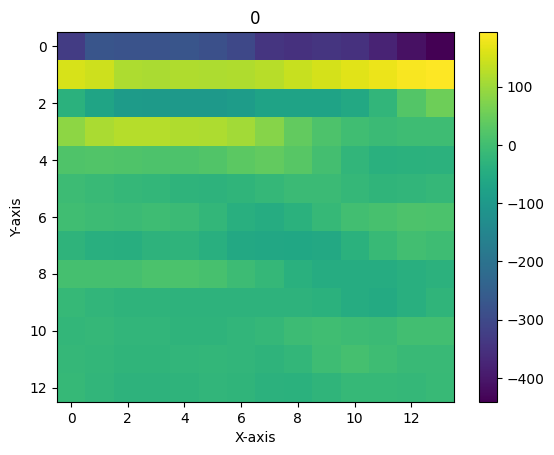

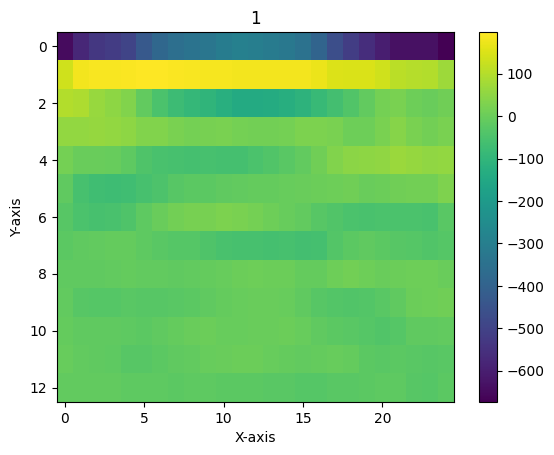

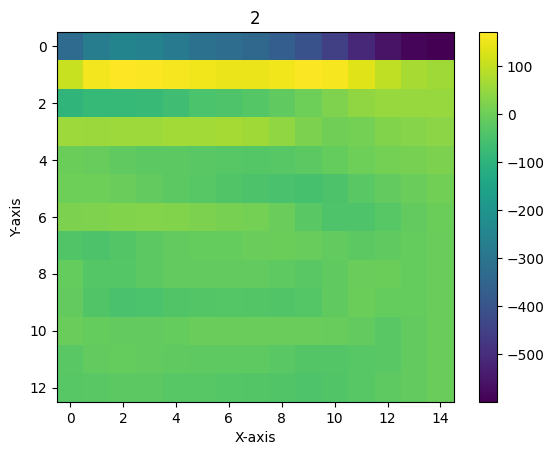

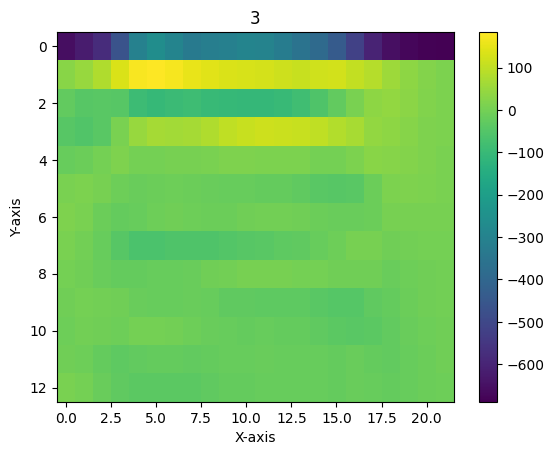

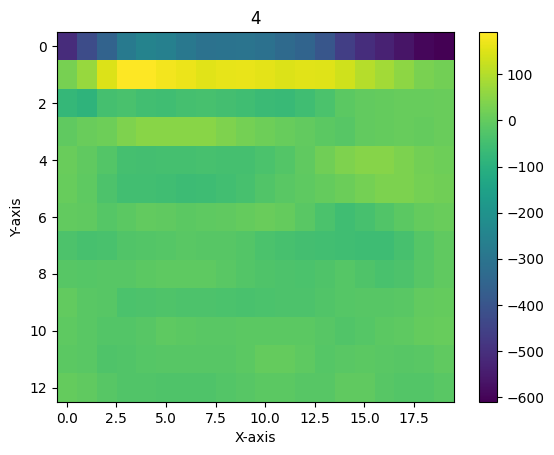

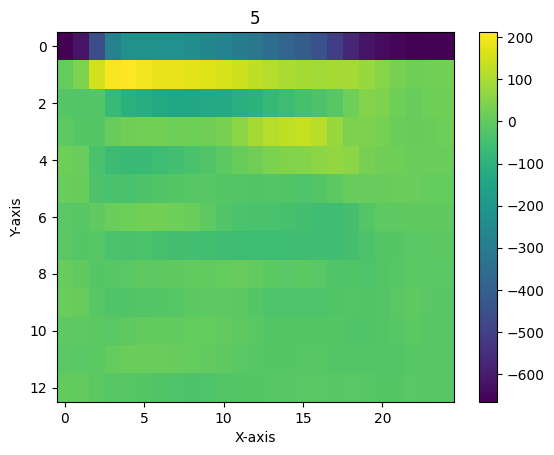

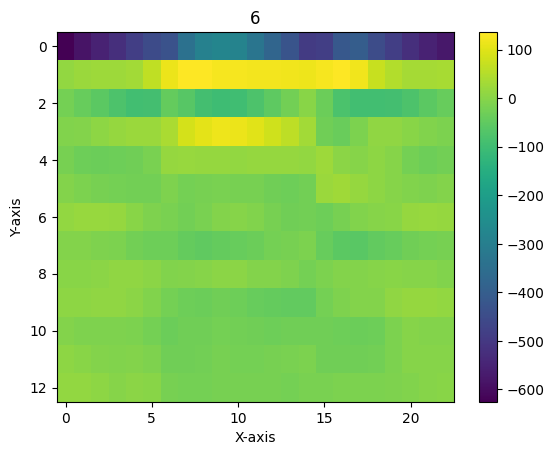

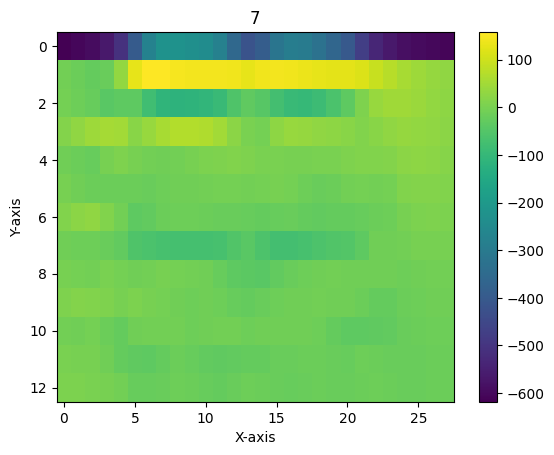

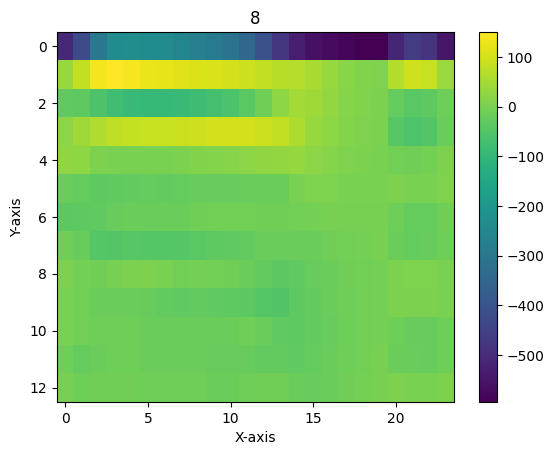

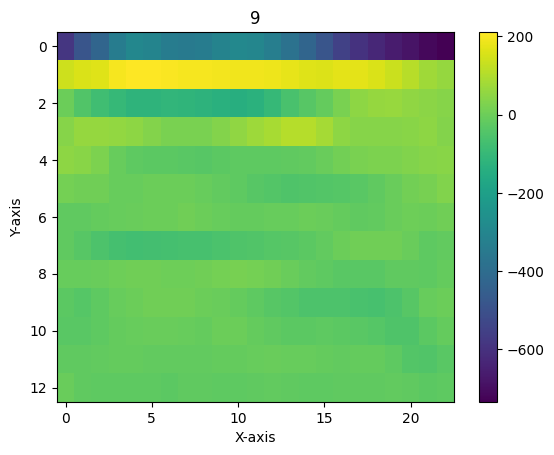

In [76]:
for i in range(numberOfClasses):
    plt.imshow(categorizedMfccVec[i][0], cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(classLabels[i])
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


In [77]:
trainDatas = np.empty((numberOfClasses), dtype=object)
testDatas = np.empty((numberOfClasses), dtype=object)
for i in range(numberOfClasses):
    X_train, X_test = train_test_split(categorizedMfccVec[i], test_size=0.2, random_state=42)
    trainDatas[i] = normalize(np.concatenate(X_train, axis=1), axis=0)
    testDatas[i] = [normalize(x, axis=0) for x in X_test]

### Training With hmmlearn

In [78]:
hmm_models = np.empty(numberOfClasses, dtype=object)
for i in range(numberOfClasses):
    hmm_models[i] = GaussianHMM(n_components=13)
    hmm_models[i].fit(trainDatas[i].T)

In [91]:
predictions = []
for i in range(numberOfClasses):
    for test_query in testDatas[i]:
        scores = []
        for j in range(numberOfClasses):
            scores.append(hmm_models[j].score(test_query.T))
        predictions.append(np.argmax(scores))

In [135]:
e = Eval(classLabels, predictions)
e.calcMetrics()
e.printTotalAccuracy()

Total accuracy of model =  98.46666666666667 %


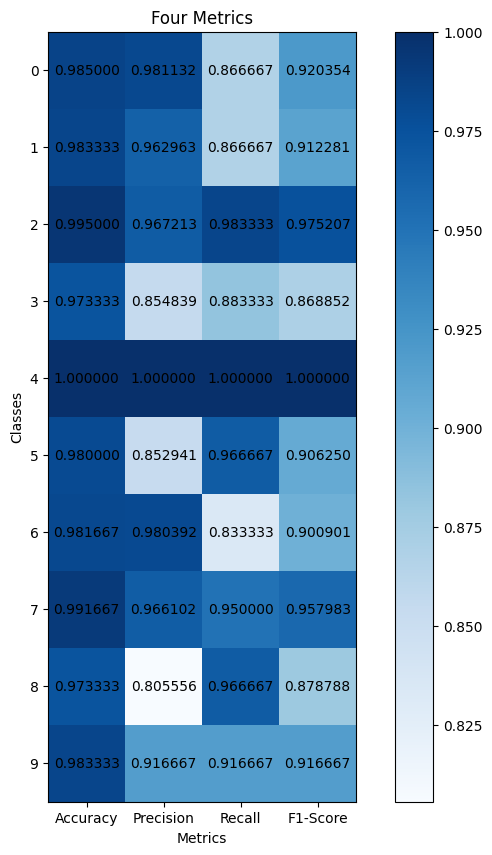

In [136]:
e.plot_per_class_metrics()

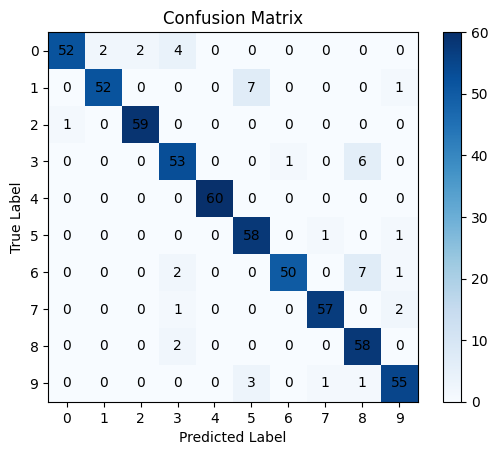

In [137]:
e.plot_confusion_matrix()

### Training with our own implementation

In [141]:
hmm_models_H = np.empty(numberOfClasses, dtype=object)
for i in range(numberOfClasses):
    hmm_models_H[i] = HMM(num_hidden_states=13)
    hmm_models_H[i].train(trainDatas[i], 10)

In [143]:
predictions = []
for i in range(numberOfClasses):
    for test_query in testDatas[i]:
        scores = []
        for j in range(numberOfClasses):
            scores.append(hmm_models_H[j].score(test_query))
        predictions.append(np.argmax(scores))

In [144]:
e = Eval(classLabels, predictions)
e.calcMetrics()
e.printTotalAccuracy()

Total accuracy of model =  90.03333333333333 %


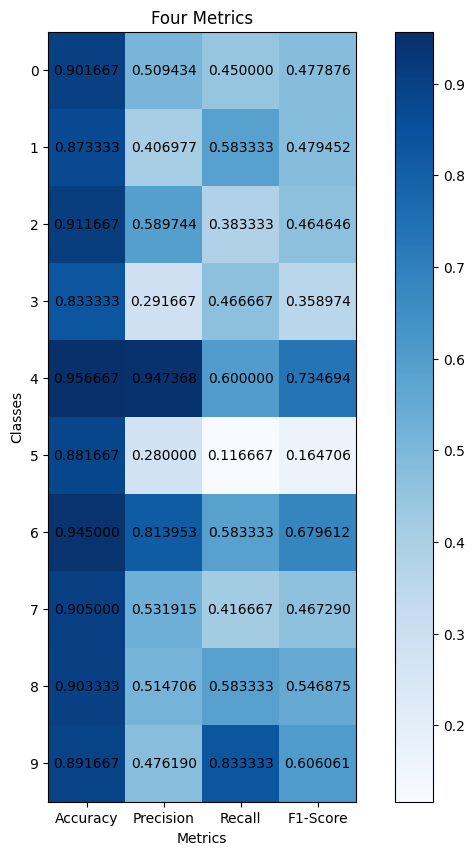

In [145]:
e.plot_per_class_metrics()

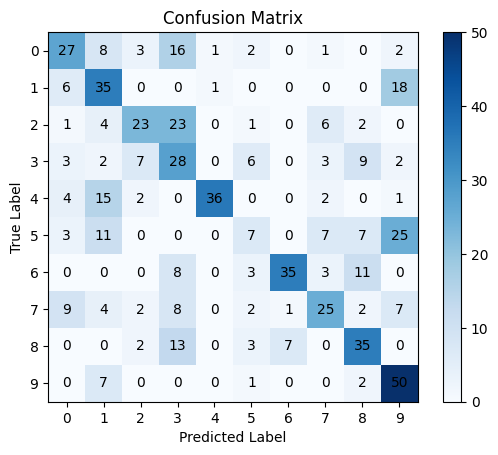

In [146]:
e.plot_confusion_matrix()

## Training On Speakers

In [151]:
numberOfClasses = 6
numberOfFilesPerClasses = 500
classLabels = ['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']

In [166]:
audioIndex = 0
numberOFFiles = len(os.listdir(dataDir))
audio = np.empty(numberOFFiles*3, dtype=object)
for fileName in os.listdir(dataDir):
    data, sr = librosa.load(os.path.join(dataDir, fileName))
    data = data[abs(data - 0) > 1e-6]
    data = nr.reduce_noise(data, sr)
    data1 = data[0:len(data)//3]
    data2 = data[len(data)//2 : 2*(len(data)//3)]
    data3 = data[2*(len(data)//3):]
    mfccVec1 = librosa.feature.mfcc(y=data1, n_mfcc=13, n_fft = min(2048, len(data1)), sr=sr)
    mfccVec2 = librosa.feature.mfcc(y=data2, n_mfcc=13, n_fft = min(2048, len(data2)), sr=sr)
    mfccVec3 = librosa.feature.mfcc(y=data3, n_mfcc=13, n_fft = min(2048, len(data3)), sr=sr)
    audio[audioIndex] = mfccVec1[:, 0:45]
    audio[audioIndex + 1] = mfccVec2[:, 0:45]
    audio[audioIndex + 2] = mfccVec3[:, 0:45]
    audioIndex += 3
print("number of created samples : ", audioIndex)

number of created samples :  9000


In [168]:
categorizedMfccVec = np.empty((numberOfClasses, numberOfFilesPerClasses), dtype=object)
for i in range(numberOfClasses):
    tmp = []
    for j in range(10):
        tmp.append(audio[j*900 + i*150:j*900 + (i+1)*150])
    categorizedMfccVec[i] = np.array(tmp).flatten()
    

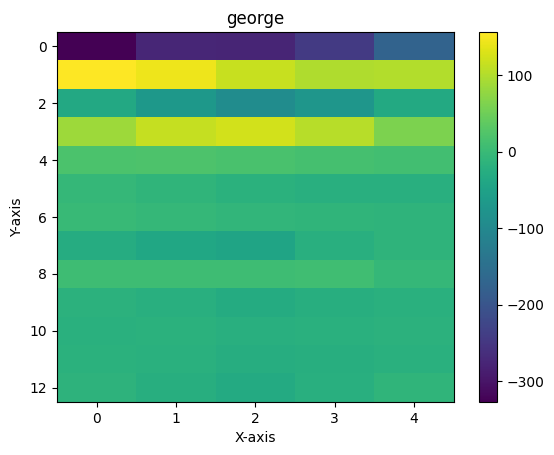

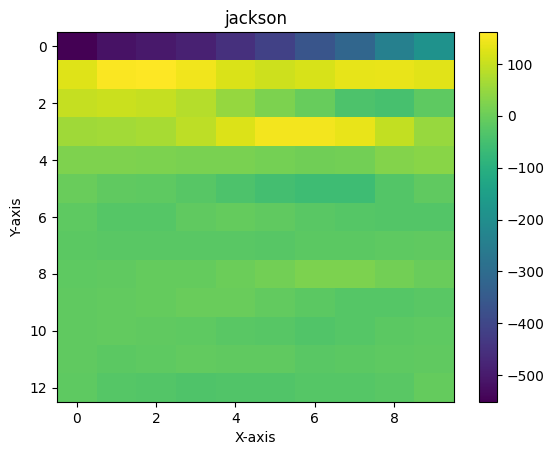

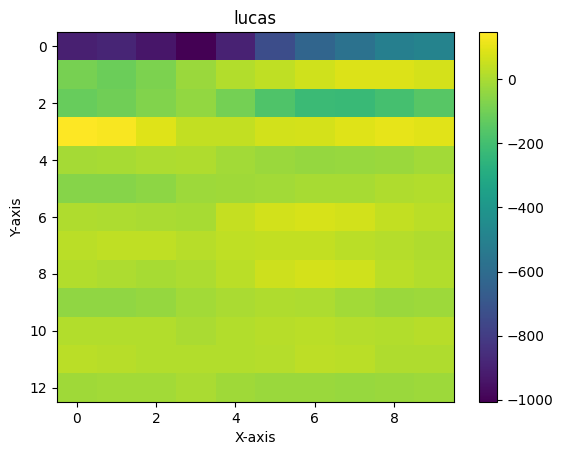

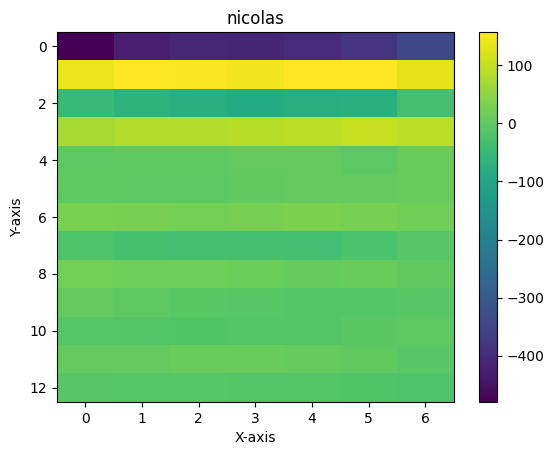

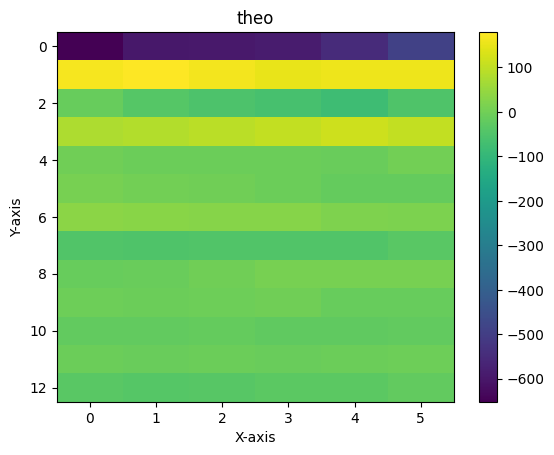

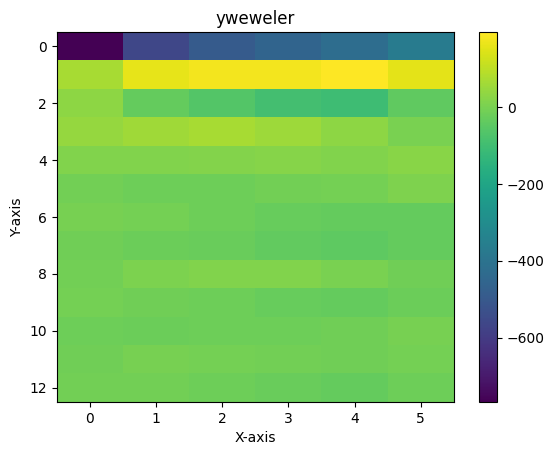

In [172]:
for i in range(numberOfClasses):
    plt.imshow(categorizedMfccVec[i][0], cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(classLabels[i])
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


In [173]:
trainDatas = np.empty((numberOfClasses), dtype=object)
testDatas = np.empty((numberOfClasses), dtype=object)
for i in range(numberOfClasses):
    X_train, X_test = train_test_split(categorizedMfccVec[i], test_size=0.2, random_state=42)
    trainDatas[i] = normalize(np.concatenate(X_train, axis=1), axis=0)
    testDatas[i] = [normalize(x, axis=0) for x in X_test]

### Training With hmmlearn

In [174]:
hmm_models = np.empty(numberOfClasses, dtype=object)
for i in range(numberOfClasses):
    hmm_models[i] = GaussianHMM(n_components=13)
    hmm_models[i].fit(trainDatas[i].T)

In [175]:
predictions = []
for i in range(numberOfClasses):
    for test_query in testDatas[i]:
        scores = []
        for j in range(numberOfClasses):
            scores.append(hmm_models[j].score(test_query.T))
        predictions.append(np.argmax(scores))

In [176]:
e = Eval(classLabels, predictions)
e.calcMetrics()
e.printTotalAccuracy()

Total accuracy of model =  91.87037037037037 %


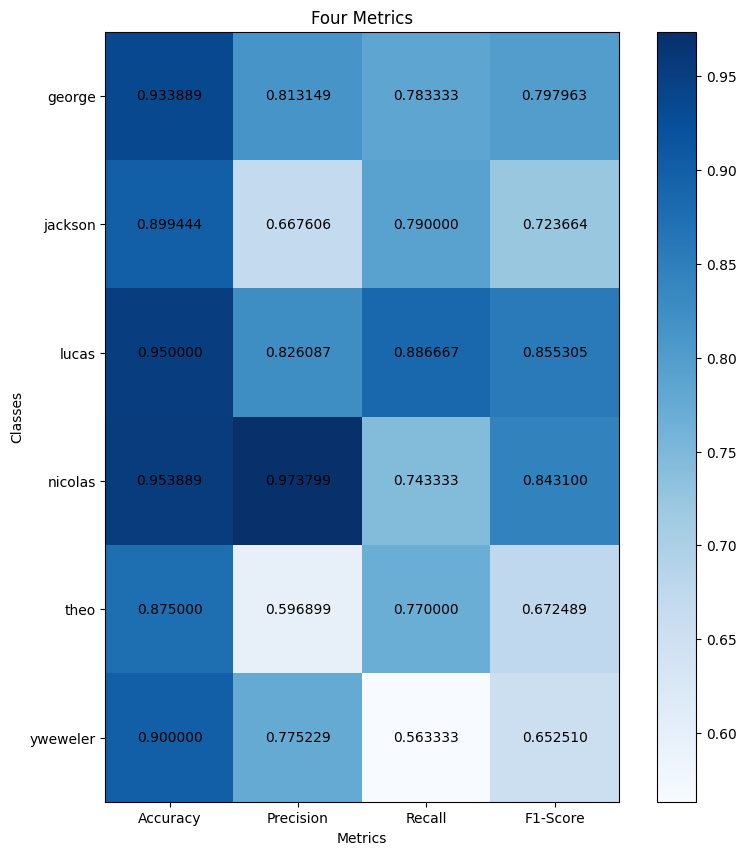

In [177]:
e.plot_per_class_metrics()

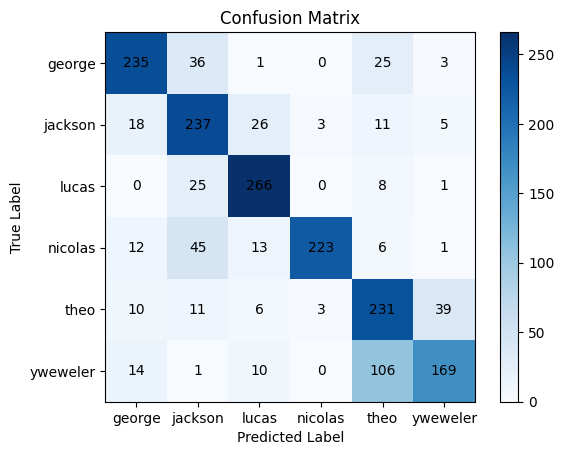

In [178]:
e.plot_confusion_matrix()